# Advances in Data Mining
## Assignment 2

**Course**: 	Advances in Data Mining  
**Year**: 	2019-2020  
**Assignment**:	2 (Local sensitive hashing)  
**Authors**: 	[Alexandre Cirilo](mailto://s2377640@umail.leidenuniv.nl) (2377640)  
**Program**: 	Computer Science (Bioinformatics)

### Introduction

In this assignment, we are provided with a file (*user_movie.npy*) consisting of about 65 million rows and 2 columns, each row reflecting the relation: ```<user_id, movie_id>``` (i.e. user *x* watched movie *y*). In total, there are 103703 unique users, and 17700 unique movies. This data comprehends an extract from the Netflix challenge.


The aim of this work is to find, with the help of LSH (**Local Sensitive Hashing**), pairs of users whose jaccard similarity is higher than 0.5.

Here, we resort to LSH instead of the brute-force search to find the aforementioned pairs of users since the latter would force us to calculate the Jaccard similarity score for about $5.377 \times 10^{9}$ pairs (i.e. about 5 billion pairs), which would be too expensive.

#### Data Preprocessing

First and foremost, we need to preprocess the data in such a way that we can represent it in a **sparse** matrix format (in this assignment, we chose to use the CSR - *Compressed Sparse Row* - format) that will be our *characteristic matrix*. In this matrix, columns represent users and rows represent movies.

If a specific user has seen a determinate movie, then: ```sparse(user, movie) = 1```; meaning that our (Boolean) matrix will hold value **1** (*True*) whenever a user has seen a movie, and **0** otherwise (*False*).

We chose to use a sparse matrix to represent our data since the data itself is quite sparse, i.e. all users have watched between 300 and 3000 movies (out of the total 17700 movies), meaning that most entries in the matrix will be zero. By using a sparse matrix, we are only storing non-zero values, assuming the remaining entries are zeros. This approach saves a lot of memory and computing time. In fact, you can often encounter such matrices when working with NLP (Neuro-Linguistic Programming) or machine learning tasks. More specifically, we chose to use the CSR format for the sparse matrix because of its efficient item access and slicing, and fast arithmetics.

#### Minhashing

With minhashing, one aims to build a signature matrix which is composed of *p* rows, respective to the number of permutations we perform on the rows of the original characteristic (sparse) matrix (i.e. movies), and *c* columns, where each column refers to one single user (thus, we will have 103703 columns, in this assignment).

To perform minhashing, as said beforehand, we perform *p* permutations on the rows of the characteristic (sparse) matrix. Then, for a determinate permutation, and for each column (i.e. for each user), the minhash value will be equal to the index of the first row containing a non-zero value (i.e. 1; that is, a movie an user has seen). We repeat this process for every user, *p* times. In the end, we will have generated a signature matrix of size $p \times c$, where $p$ refers to the number of permutations, and $c$ to the number of users in the dataset.

#### LSH

Our goal here is to find the most similar pairs of users above a certain threshold $t$; similarity between users is defined by the number of movies they have seen in common. The train of thought is that we are only going to focus on the pairs that are most likely to be similar, avoiding the need of an expensive brute-force search by not evaluating the similarity between pairs that are not likely to share attributes (in this case, movies seen by both users in a determinate pair). The general approach to such problem is to turn to *local sensitive hashing* (LSH), also termed *near-neighbour search*.

The main idea to LSH is to apply a hash function, in this case, to each user (taking into account the movies they have seen), such that similar users (meaning they share several movies they both watched) are more likely to be hashed to the same bucket. Like so, we are trying to minimize hashing dissimilar users to the same bucket, in such a fashion that we only need to compute the Jaccard similarity score for each user pair combination - *candidate pairs* - in a given bucket. Hopefully, only the most similar users will end up in the same bucket, and if one or more dissimilar user(s) also end up in that particular bucket, we call them *false positives*. This way, we save up a lot of time, since, in the ideal case, we are only calculating the similarity between users likely to be similar.

##### Banding Technique

Following the generation of the signature matrix, one can divide it into **_b_** bands consisting of **_r_** rows each. For each band, each column will be hashed to a specific bucket. Here, columns with the same tuple (vector of integers of length *r* corresponding to the minhash values for each user in a specific band) will be hashed to the same bucket. Note that we use a separate bucket array for each band to avoid hashing columns with the same vector in different band to the same bucket. As expected, this approach makes similar columns much more likely to be candidate pairs than dissimilar ones.

###### Probabilities

1. Probability that the signatures agree in all rows of one particular band: $s^{r}$.
2. Probability that the signatures disagree in at least one row of a particular bnad: $1-s^{r}$.
3. Probability that the signatures disagree in at least one row of each of the bands: $(1-s^{r})^{b}$.
4. Probability that the signatures agree in all the rows of at least one band, and thus become a candidate pair: $1-(1-s^{r})^{b}$.

Regardless of the chosen constants *b* and *r*, the function has the form of an *S-curve* in which the threshold *t* (i.e. similarity score at wich the probability of becoming a candidate pair is 1/2) is a function of *b* and *r*. A good approximation to the threshold is:

\begin{equation}
s=(1/b)^{\frac{1}{r}}
\end{equation}

Hence, since the threshold in this work is fixed to 0.5, we want to approximate the equation shown above to 0.5. Some settings that approximate to 0.5 are listed in the table below.

| *s* | *b*|*r*| *p* |
|:---:|:--:|:-:|:---:|
| 0.5 | 16 | 4 |  64 |
| 0.5 | 20 | 5 | 100 |
| 0.5 | 24 | 6 | 216 |

After having tried different combinations of *b* and *r*, we chose to stick with: $b=20$ and $r=5$. Using shorter values for *r* takes up much more time at the jaccard similarity score computation step since it will generate more candidate pairs (lower *r* implies higher probability of hashing users to the same bucket, and thus many more pairs need to be evaluated). On the other hand, using higher values for *b*, notwithstanding higher number of pairs to be evaluated, also takes up more time since we need to generate more permutations (e.g. 216 instead of 100, in the case shown in the table above).

#### Jaccard Similarity

The Jaccard similarity (coefficient) of a set is given by:

\begin{equation}
J(A, B) = \frac{|A \cap B|}{|A \cup B|} = \frac{|A \cap B|}{|A| + |B| - A \cap B|}
\end{equation}

For the calculation of the Jaccard similarity score, in the current implementation, we will take advantage of the *set* data structure in Python (which is described as an "unordered collections of unique elements" in the documentation) which allow for fast intersection and union calculation between two sets.

### Workflow

In this assignment, the workflow enumerated below will be followed in order to find pairs of similar users (users that have seen several movies in common) above a threshold of 0.5:

0. (<font color='red'>Checkpoint</font>: check that at least on Jaccard similarity calculation method is picked)

1. **Load** the data from *user_movie.npy*.
    1. <font color='red'>Checkpoint</font>: check if $p = b \times r$ and $t \in [0, 1]$.
2. **Preprocess** the data:
    1. Create the *seen_per_user* list which holds, for each user, the list of movies seen by that user. This variable will be assessed to check for the set of movies watched by a given user instead of checking the sparse matrix later on in an attempt to speed up the whole process.
    2. Generate a sparse matrix in *CSR* format (**SciPy**) with columns representing users, rows representing movies, with values of 1 (if user *x* has seen movie *y*), and 0 otherwise.
    3. <font color='red'>Checkpoint</font>: check if the shape of the sparse matrix is in agreement with the number of users (columns) and movies (rows).
3. **Minhash** the data:
    1. Initialize the signature matrix by calling *np.zeros(...)* (**NumPy**) with shape ($p$, $nu$), where $p$ is the number of permutations and $nu$ the number of users.
    2. <font color='blue'>Multiprocessing</font>: parallellize (pool with 8 processes in our system) the generation of the signature matrix. This is repeated $p$ times (i.e. number of permutations) to generate the signature matrix. Using multiprocessing here turns out to be around 1.7x faster than the canonical approach, as shown in the plot below (signature length *vs.* runtime for 6 different signature lengths).
        1. Generate the permutations of rows in the characteristic (sparse) matrix.
        2. Return the minhash value for each user.
    3. Populate the empty signature matrix created in step 1 with each generated row of the signature matrix, accordingly.
    4. <font color='red'>Checkpoint</font>: check if the shape of the signature matrix is in agreement with the number of permutations (rows) and users (columns).
4. **LSH**:
    1. Split the signature matrix in $b$ matrices, where $b$ corresponds to the number of bands.
    2. Initialize a list of $b$ (number of bands) bucket dictionaries where each bucket dictionary holds several entries with:
        - Key: Hashed tuple value (i.e. column respective to a specific user in a specific band).
        - Value: User with hashed tuple of value *key*.
    3. Initialize an empty dictionary *tmp* where:
        - Key: Hashed value of a specific bucket.
        - Value: 1.
    4. For each bucket in each band, hash the entire bucket (i.e. set of users contained in that bucket). The hashed value will be the key for the *tmp* dictionary, such that ```tmp[key] = 1```.
    5. Repeat the process for every bucket and at each step, check ```tmp[key]``` already exists. If it does, it means we have two identical buckets in different bands (i.e. buckets with exactly the same content; list of users). It is pointless to re-evaluate potential candidate pairs present in identical buckets; we only want to check them once. Thus, if we find another bucket identical to a previous one, we remove it from the from the bucket array (by removing it from the dictionary that represent the band in which it appeared).
    6. Generate *candidate pairs* for each band using combinations of users without repetition in each bucket. Note that only buckets containing 2 or more users will be considered in this step, since we need 2 or more users to generate candidate pairs.
    7. Candidate pairs are added to the ```candidates_vector``` variable (type *set* to hold unique pairs only).
5. **Compute Jaccard similarity**:
    The ```jaccard``` function defined in the ```LSH``` class accepts the ```candidates_vector``` variable defined in the previous step, the signature matrix, as well as 3 arguments that define how the Jaccard similarity score is calculated:
    - ```on_sig (bool)```: if *True*, similarity is calculated directly on the signature matrix taking into account two sets taken from the columns that represents each user (one column in the signature matrix represents one single user), respectively.
    - ```on_sparse (bool)```: if *True*, similarity is calculated on the sparse matrix using the ```seen_per_user``` variable (list containing the movies seen per user, i.e. *user ID* equals the index in the list).
    - ```on_both (bool)```: if *True*, similarity is first calculated on the signature matrix and then proofread by calculating the similarity on the resulting pairs.
    1. Initialize variables:
        1. ```self.pairs_dict```: dictionary that will keep reference to all the pairs found for each of the selected Jaccard similarity calculation methods.
        2. ```JS_calc```: list that holds the boolean values respective to each Jaccard similarity calculation method (*True* if method will be performd, *False* otherwise).
    2. For each chosen Jaccard similarity calculation method:
        1. Create a ```self.iterable``` variable consisting of:
            - User IDs (for *user1* and *user2* in the pair).
            - Sets of movies seen for each user.
            - Threshold (in this case: 0.5).
        2. Call the ```jaccard_parallel``` function: also has a default keyword argument ```on_both_step``` (*True* if first step of the 'on_both' Jaccard similarity calculation method, in which case we do not want to add the pairs found to the 'pairs_dict' variable yet, i.e. we still need to proofread those pairs on the sparse matrix first).
            1. Creates a pool of processes run in parallel (pool with 8 processes in our system).
            2. Calls the ```similarity``` function from ```parallelize.py``` which calculates the Jaccard similarity score (on candidate pairs found in the ```self.iterable``` variable) and returns a tuple if a given pair of users has a similarity score equal or above the set threshold, otherwise returns *None*.
            3. Cleaning up the output:
                1. Cleaning up pairs (removes pairs with score lower than threshold).
                2. Sort by first value in tuple (i.e. *user1*).
                3. Append found sets of pairs to the ```self.pairs_dict``` variable 
                   according to the chosen calculation method.
       3. Call the ```save``` function:
           - ```file``` argument: name of the file to be generated.
           - ```data```: pairs of similar users found (uses the variable ```self.pairs_dict[method]```, where *method* is on of the following: *on_sig*, *on_sparse*, or *on_both*. 

#### Comments

- Pivotal to this assignment, is the notion that the probability that the minhash function for a random permutation of rows produces the same value for two sets approximates the Jaccard similarity of those particular sets.
- With regards to the hash functions and the generated buckets (for each band), the standard Python hash function (```hash(...)```)  will be used, and the buckets will be represented by the hashed values themselves. As stated in the documentation: "they are used to quickly compare dictionary keys during a dictionary lookup", making it appropriate for our problem.
- To tackle the long runtimes observed during the Jaccard similarity calculation step in our implementation, we decided to take advantage of the **multiprocessing** module. Even though it was not encouraged as stated in the feedback for the assignment 1 of the Advances in Data Mining course (Fall 2019), we observe a substantial decrease in runtime when using a pool of 8 processes that parallelize the calculation of the similarity score on a set of candidate pairs (this was performed with the 'on_sparse' approach only). Hence, we decided to use it in 2 occasions:
    1. During the generation of the signature matrix, to generate the index of permuted rows of the characteristic (sparse) matrix, and return the first occurence of a non-zero value in the subsequent matrix for each user (```permute``` function).
    2. During the calculation of the Jaccard similarity score between pairs of users (```similarity``` function).
- Both functions listed above are stored in the **_parallelize.py_** file. Thus, we need to import ```parallelize``` first to be able to call them.
- Our implementation outputs 3 files (in the case where we decide to set 'on_sig' ,'on_sparse', and 'on_both' to *True*). Note that only **ans.txt** (output from 'on_both') should be taken into account. The remaining two files are there solely for discussion and analysis.

Average ratio w/:w/o multiprocessing: ~1.71x faster.


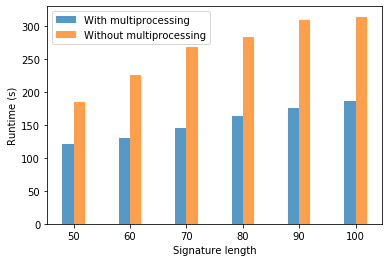

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

# Timings (ran on different signature lengths for 'on_sparse')
parallel, serial = [121.04, 129.90, 145.12, 162.95, 174.79, 186.67], [183.88, 225.09, 268.36, 283.025, 308.81, 313.56]

fig, ax = plt.subplots()
rect1 = plt.bar([i*10-1 for i in range(5, 11)], parallel, width=2, alpha=0.75, label="With multiprocessing")
rect2 = plt.bar([i*10+1 for i in range(5, 11)], serial, width=2, alpha=0.75, label="Without multiprocessing")
plt.legend()
ax.set_xlabel("Signature length")
ax.set_ylabel("Runtime (s)")

# Average ratios w/:w/o multiprocessing for each signature length
avg = [s/p for p, s in zip(parallel, serial)]
print("Average ratio w/:w/o multiprocessing: ~{}x faster.".format(round(np.mean(avg), 2)))

### Code

The code itself consists in a class ```LSH``` containing multiple functions that act as building blocks and follow the workflow stated beforehand. At every occasion deemed necessary or non-trivial, comments are added directly above, or next to, the line of code in question.

In [2]:
class LSH:
    
    def __init__(self, p, b, r, t, on_sig, on_sparse, on_both):
        """
        p: Number of permutations (i.e. signature length)
        b: Number of bands
        r: Number of rows
        t: Threshold (takes a value between 0 and 1)
        """
        self.p, self.b, self.r, self.t = p, b, r, t
        self.on_sig, self.on_sparse, self.on_both = on_sig, on_sparse, on_both
        
        # Check if given parameters are acceptable
        try:
            assert p ==  b * r and 0 <= t <= 1, "Failed"
        except AssertionError as error:
            print(error)
            return

        # Loading 'user_movie.npy'
        self.load(file="user_movie.npy")
    
    def load(self, file):
        """
        Loads the user_movie.npy array and assigns it to the variable 'data'.
        """
        data = np.load(file)

        # Preprocessing data
        print("Preprocessing data...", end="\t\t\t")
        return self.preprocess(data)
    
    def preprocess(self, data):
        """
        Creates a list of movies seen per user (self.seen_per_user) and generates a sparse matrix.
        """
        # Number of users and movies
        self.nu, self.nm = len(np.unique(data[:, 0])), len(np.unique(data[:, 1]))
        # User IDs (and range), Movie IDs
        (self.users, self.indices), self.movies = np.unique(data[:, 0], return_counts=True), np.unique(data[:, 1])
        
        # 'seen_per_user' list keeps a list of the movies seen by each user
        # e.g. seen_per_user[0] = [...] (for user ID = 0)
        start, self.seen_per_user = 0, []
        for index in np.cumsum(self.indices, dtype=int):
            self.seen_per_user.append(data[start:index, 1])
            start = index
        print("OK")
        
        print("Generating sparse matrix...", end="\t\t")
        # Generating data to populate sparse matrix in CSR format
        rows = list(chain(*self.seen_per_user))                                             # Movies (1D)
        cols = [[i] * len(self.seen_per_user[i]) for i in range(len(self.seen_per_user))]   # Users
        cols = list(chain(*cols))                                                           # Users (1D)
        data = [True] * len(rows)                                                           # Set 'True' if seen
        # Populating sparse matrix (Compressed Sparse Row format)
        sparse = csr_matrix((data, (rows, cols)), dtype=bool)
        print("OK")
        
        try:
            print("\vCheck sparse matrix shape...", end="\t\t")
            assert sparse.shape  == (self.nm, self.nu), "Failed"
            print("OK")
        except AssertionError as error:
            print(error)
            return
        
        # MinHashing
        return self.minhash(sparse)
    
    def minhash(self, sparse):
        """       
        The Jaccard similarity coefficient is a commonly used indicator of the similarity between two sets.
        Two sets are more similar (i.e. have relatively more members in common) when their Jaccard index is closer to 1.
        The goal of MinHashing is to estimate J(A,B) quickly, without explicitly computing the intersection and union.
        """
        
        print("Generating signature matrix...", end="\t\t")
        # Initialize signature matrix
        sig = np.zeros((self.p, self.nu))

        # Permute 'p' times the rows (i.e. movies) of the sparse matrix
        # And get the first non-zero (i.e. 'True') element for each column (i.e. user)
        with mp.Pool(mp.cpu_count()) as pool:
            iterable = [(permutation, sparse, sig) for permutation in range(self.p)]
            tmp = pool.starmap(parallelize.permute, iterable)
        # Each permutation (one minhash value for each user) is a row in the resulting signature matrix
        for permutation, row in tmp:
            sig[permutation] = row
        # Delete unused variables
        del iterable, tmp
        print("OK")
        
        try:
            print("\vCheck signature matrix shape...", end="\t")
            assert sparse.shape  == (self.nm, self.nu), "Failed"
            print("OK")
        except AssertionError as error:
            print(error)
            return
        
        return self.lsh(sig, sparse)

    def lsh(self, sig, sparse):
        """
        Divides matrix M into b bands of r rows.
        For each band, hash each column to a hash table with k buckets.
        Candidate column pairs are those that hash to the same bucket for ≥ 1 band.
        Values of b and r can be tuned to catch most similar pairs and few nonsimilar pairs.
        
        LSH involves a tradeoff:
        If avoidance of false negatives is important, select b and r to produce a threshold lower than t.
        If speed is important and you wish to limit false positives, select b and r to produce a higher threshold.
        """
        # Split signature matrix according to defined b bands
        matrices = np.array_split(sig, self.b)
        
        # 'buckets' is a list of dictionaries with keys as hash values containing users with respective hash
        buckets = [{} for i in range(self.b)]
        # Generating and filling buckets        
        print("Hashing users...", end="\t\t\t")
        for band in range(self.b):
            buckets[band] = collections.defaultdict(set)
            # Each band is a list of hashed tuples (each tuple is a column, i.e. a user)
            for user in self.users:
                key = hash(tuple(matrices[band][:, user]))
                # Users with the same hash value go to the same bucket
                buckets[band][key].add(user)
        print("OK\t{}".format(sum([len(buckets[i].keys()) for i in range(len(buckets))])))
        
        print("Hashing buckets...", end="\t\t\t")
        tmp = {}
        for band in range(self.b):
            for key in list(buckets[band].keys()):
                # If hash value of bucket already exists, delete this bucket
                # (to avoid checking identical bucket)
                try:
                    tmp[hash(frozenset(buckets[band][key]))]
                    del buckets[band][key]
                except:
                    tmp[hash(frozenset(buckets[band][key]))] = True
        # Keep reference of the number of buckets
        self.n_buckets = len(tmp)
        # Delete unused variable
        del tmp
        
        print("OK\t{}".format(self.n_buckets))
        
        # Check potential candidates in buckets
        candidates_vector = set()
        print("Generating candidate pairs...", end="\t\t")
        for band in range(self.b):
            for key in list(buckets[band].keys()):
                # Only check buckets with two or more candidates (pairs)
                if len(list(buckets[band].keys())) >= 2:
                    candidates = list(combinations(buckets[band][key], 2))
                    for (user1, user2) in candidates:
                        candidates_vector.add((user1, user2))
        print("OK\t{}".format(len(candidates_vector)))
        
        # Compute Jaccard similarity on candidates
        self.jaccard(candidates_vector, sig, self.on_sig, on_sparse, self.on_both)
    
    def jaccard(self, candidates_vector, sig, on_sig, on_sparse, on_both):
        """
        Computes the Jaccard similarity score on the candidate pairs and dumps it
        in CSV format in a .txt file.
        Arguments:
            - on_sig:    'True' if similarity is calculated on the signature matrix
            - on_sparse: 'True' if similarity is calculated on the sparse matrix
            - on_both:   'True' if similarity is calculated on the sparse matrix 
                                (after checking similarity on signature matrix)
        """
        print("Computing Jaccard similarity...", end="\t\t")
        # 'self.pairs_dict' holds all the pairs found for each JS calculation method
        self.pairs_dict = {"on_sig": [], "on_sparse": [], "on_both": []}
        # JS_calc list keeps track of which JS calculation methods were selected
        JS_calc = [on_sig, on_sparse, on_both]
        
        for method in self.pairs_dict.keys():
            # Compute JS score only in selected methods (i.e. if 'True' or 1)
            if locals()[method]:
                # If JS calculated on signature matrix
                if method is "on_sig":
                    # Keep record of starting point (time) of JS calculation
                    timer_start = time.time()
                    # Generate one set for each user of length 'p' (i.e. number of permutations)
                    sig_sets = [set(i) for i in sig.T]
                    # Generate 'self.iterable' for parallelization of JS calculation
                    self.iterable = [(user1, user2, sig_sets[user1], sig_sets[user2], self.t) 
                                for (user1, user2) in candidates_vector]
                    # Run JS calculation in parallel
                    self.jaccard_parallel(method)
                    # Dump found pairs to .txt file in CSV format
                    self.save(file="ans_sig.txt", data=self.pairs_dict["on_sig"])
                    # Determine elapsed time for JS calculation and store it in 'times' variable
                    times["on_sig"] = time.time()-timer_start
                
                if method is "on_sparse":
                    timer_start = time.time()
                    """
                    If jaccard similarity score calculated on the characteristic (sparse) matrix
                    Here, we take advantage of the variable 'seen_per_user' that keeps the movies seen by a specific user
                    e.g. seen_per_user[0] = [29, (...)], where '0' refers to the user ID = 0
                    """
                    self.iterable = [(user1, user2, self.seen_per_user[user1], self.seen_per_user[user2], self.t)
                                for (user1, user2) in candidates_vector]
                    self.jaccard_parallel(method)
                    self.save(file="ans_spr.txt", data=self.pairs_dict["on_sparse"])
                    times["on_sparse"] = time.time()-timer_start
                        
                if method is "on_both":
                    timer_start = time.time()
                    sig_sets = [set(i) for i in sig.T]
                    self.iterable = [(user1, user2, sig_sets[user1], sig_sets[user2], self.t) 
                                for (user1, user2) in candidates_vector]
                    self.jaccard_parallel(method, on_both_step=True)
                    # Calculate JS similarity score on sparse matrix after checking similarity in signature matrix
                    self.iterable = [(user1, user2, self.seen_per_user[user1], self.seen_per_user[user2], self.t)
                                for (user1, user2) in self.pairs]
                    self.jaccard_parallel(method)
                    self.save(file="ans.txt", data=self.pairs_dict["on_both"])
                    times["on_both"] = time.time()-timer_start
        
        # Finished computing JS score
        print("OK", end="\t")
        
        # Print number of pairs found for each chosen method
        for method in self.pairs_dict.keys():
            if locals()[method]:
                print("{}".format(len(self.pairs_dict[method])), end=" ")
        
        # Log progress
        logger["p:{} b:{} r:{} t:{}".format(self.p, self.b, self.r, self.t)] = \
            self.n_buckets, len(candidates_vector), len(self.pairs_dict["on_sig"]), \
            len(self.pairs_dict["on_sparse"]), len(self.pairs_dict["on_both"])
    
    def jaccard_parallel(self, method, on_both_step=False):
        """
        Creates a pool of 'x' processes (where 'x' equals the number of cores of the system).
        This reduces the time taken to compute the JS score between candidate pairs (self.iterable).
        """
        with mp.Pool(mp.cpu_count()) as pool:
            self.pairs = pool.starmap(parallelize.similarity, self.iterable)
        
        """
        Process output:
            1. Cleaning up pairs (removes pairs with score lower than threshold).
               (i.e. when parallelize.similarity returns 'None)
            2. Sort by first value in tuple (i.e. user1).
            3. Append found sets of pairs to the 'self.pairs_dict' variable 
               according to the chosen calculation method.
        """
        self.pairs = [i for i in self.pairs if i]
        self.pairs = sorted(self.pairs, key=lambda x: x[0])
        self.pairs = set(self.pairs)
        # 'on_both' intermediate processing step is not appended to the final pairs
        # Needs to be processed further after evaluation of JS score on sparse matrix
        if not on_both_step:
            self.pairs_dict[method] = self.pairs

    def save(self, file, data):
        """
        Saves data in CSV format to a .txt file.
        """
        with open(file, mode="w") as csv_file:
            writer = csv.writer(csv_file, delimiter=",", lineterminator="\n")
            for row in data:
                writer.writerow(row)

### Parameters

In [3]:
# Import 'parallelize.py' which includes the 'permute' and 'similarity' functions
import csv, tabulate, collections, multiprocessing as mp, parallelize, time
from scipy.sparse import csr_matrix
from itertools import combinations, chain
from IPython.display import HTML, display

# Setting random seed generator for reproducibility
np.random.seed(seed=2019)

"""
logger:         Logs all the relevant data (buckets, pairs of users found)
times:          Keeps track of the time it took to run a given setting
setting:        Tune this variable to change the paramenters of the LSH algorithm (p, b, r, t, on_sparse, and on_sig)
  - p:          Signature length
  - b:          Number of bands
  - r:          Number of rows per band
  - t:          Threshold (between 0 to 1)
  - on_sig:     True if Jaccard similarity (JS) score calculated on the signature matrix
  - on_sparse:  True if Jaccard similarity (JS) score calculated on the sparse matrix
  - on_both:    True if Jaccard similarity (JS) score calulated on the sparse matrix after filtering through the signature matrix

    List of settings in the form [p, b, r, t, on_sig, on_sparse, on_both]
    i.e. [[settings_1], [settings_2], etc.], where settings_x=[p, b, r, t, on_sig, on_sparse, on_both]
"""

global logger, times
logger, times, settings = {}, {"on_sig": 0, "on_sparse": 0, "on_both": 0}, [[100, 20, 5, 0.5, False, False, True]]

for p, b, r, t, on_sig, on_sparse, on_both in settings:
    # At least one JS calculation method must be set to 'True'
    assert on_sig or on_sparse or on_both, "At least one JS calculation method must be set to 'True'"
    
    # Display table with chosen parameters
    params = [[p, b, r, t, on_sig, on_sparse, on_both]]
    headers=["p", "b", "r", "t", "on_sig", "on_sparse", "on_both"]
    display(HTML(tabulate.tabulate(params, headers, tablefmt="html")))
    
    # LSH implementation
    LSH(p, b, r, t, on_sig, on_sparse, on_both)

p,b,r,t,on_sig,on_sparse,on_both
100,20,5,0.5,False,False,True


Preprocessing data...			OK
Generating sparse matrix...		OK
Check sparse matrix shape...		OK
Generating signature matrix...		OK
Check signature matrix shape...	OK
Hashing users...			OK	1174865
Hashing buckets...			OK	293822
Generating candidate pairs...		OK	39025323
Computing Jaccard similarity...		OK	526 

#### Post-processing

Here we simply sort the output files by the value of the first column (i.e. "user1").

In [4]:
import pandas as pd

files = ["ans_sig.txt", "ans_spr.txt", "ans.txt"]

for ans in files:
    # Only check files that exist
    try:
        tmp = pd.read_csv(ans, names=["user1", "user2"])
        tmp = tmp.sort_values("user1")
        tmp.to_csv(ans, header=None, index=False)
    except FileNotFoundError:
        pass
del tmp

### Results & Discussion

#### Summary of output

As seen in the table shown below, the 'on_sig' method found the highest number of pairs, followed by the 'on_sparse' and 'on_both' methods which differ by a mere 15 pairs.
At first glance, the 'on_sig' method results feel overwhelming, but we do need to check for false positives first before jumping to any conclusion.

In [5]:
headers=["Buckets", "Candidate pairs", "Pairs (sig)", "Pairs (sparse)", "Pairs (both)"]
pd.DataFrame.from_dict(logger, orient="index", columns=headers)

,Buckets,Candidate pairs,Pairs (sig),Pairs (sparse),Pairs (both)
p:100 b:20 r:5 t:0.5,293822,39025323,0,0,526


With regards to runtime (in seconds), clearly the 'on_sig' method is the fastest of them all (with the settings used in this execution of the implementation), followed by the 'on_both' method, and at last, by the 'on_sparse' method. The 'on_both' method was around 1.7x faster than the 'on_sparse' method, as emphasized by the barplot shown below.

In [ ]:
import pandas as pd

pd.DataFrame.from_dict(times, orient="index", columns=["Runtime (s)"])

In [ ]:
print("JS score calculation on 'on_both' is ~{}x faster than on 'on_sparse'.".format(round(times["on_sparse"]/times["on_both"], 2)))
print("It took ~{} minutes for the algorithm to run using the 'on_both' approach.".format(int(times["on_both"]/60)))

In [ ]:
%matplotlib inline

# Plotting the runtimes
rect1 = plt.bar(times.keys(), times.values(), alpha=0.75)
plt.xlabel("Jaccard similarity score calculation method")
plt.ylabel("Runtime (s)")

#### Some statistics

Truly, the 'on_sig' approach to calculate the Jaccard similarity score was the fastest of them all. But when we take a look at the false positive percentage - *fp%* - we notice that, in reality, only about 0.01% (i.e. 100-99.99) of the pairs found by this method are "true" pairs, i.e. pairs that really do have a Jaccard similarity score of 0.5 or more. Put in other words, the overwhelming majority of the pairs found in 'on_sig' are not actually similar users.

On the other side, both 'on_sparse' and 'on_both' have no false positives whatsoever. This was expected and makes total sense, since both approaches ultimately check for the similarity between users on the sparse matrix itself. The trick here is that the 'on_both' approach finds a number of pairs of similar users that comes very close to the number of pairs found by the 'on_sparse' matrix (284 vs. 298) but without the cost of checking <u>all</u> candidate pairs on the sparse matrix. That is, in the 'on_both' method, we essentially first filter through the candidate pairs by checking for their similarity on the signature matrix, and then use the subsequent candidate pairs to evaluate their similarity on the sparse matrix. What happens is that, after we evaluate the similarity between users on the signature matrix step, we will end up with a much lower number of candidate pairs to be checked on the sparse matrix. Whilst if we would directly calculate the similarity between pairs on the sparse matrix, we would have to check for a much larger number of candidate pairs.

In conclusion, at the cost of losing some potential pairs of similar users, by using the 'on_both' approach, we manage to find a close number of pairs of similar users, as compared to the ideal case ('on_sparse'), in a much shorter time.

In [ ]:
stats = {}

for ans in files:
    # If file exists
    try:
        stats[ans] = dict()
        pred = pd.read_csv(ans, names=["user1", "user2"], usecols=[0, 1])
        true = pd.read_csv("all_similar_pairs.txt", names=["user1", "user2"], usecols=[0, 1])

        # To check for duplicates and count "true" pairs (above threshold)
        tmp = pd.concat([pred, true])

        # Proofread pairs (using 'all_similar_pairs.txt')
        true_pairs = tmp.duplicated().sum()
        true_pairs_percentage = round(true_pairs/len(true)*100, 2)

        # False positives
        false_pos = len(pred) - tmp.duplicated().sum()
        false_pos_percentage = round(false_pos/len(pred)*100, 2)

        # False negatives
        false_neg = len(true) - tmp.duplicated().sum()
        false_neg_percentage = round(false_neg/len(true) * 100, 2)

        # Add to statistics
        stats[ans]["true_pairs"], stats[ans]["true_pairs%"] = true_pairs, true_pairs_percentage
        stats[ans]["fp"], stats[ans]["fp%"] = false_pos, false_pos_percentage
        stats[ans]["fn"], stats[ans]["fn%"] = false_neg, false_neg_percentage
    
    except FileNotFoundError as error:
        print(error)

# Show statistics
pd.DataFrame.from_dict(stats)

### Conclusion

With this work, we can confidently say that the using the **MinHash** algorithm provides us with a fast approximation to the Jaccard Similarity between two sets, by converting large sets - boolean arrays in the sparse matrix representing the movies seen by each user - to short signatures - MinHash signatures - while preserving similarity. Furthermore, we take advantage of **local sensitive hashing** which hashes similar users into the same buckets with high probability. This is much faster and efficient than an exhaustive search. Hence, in the context of massive datasets such as the one portrayed in this assignment, resorting to local sensitive hashing following the minhashing of our data is the most efficient solution to find a substantial number of similar pairs (in our case, pairs of users) in a relatively short amount of time (as per comparison with the brute-force approach).

With regards to the S-curve described in the introduction section:
- If avoiding false negatives is important (accuracy is important): 
    - Make $(1/b)^{\frac{1}{r}}$ smaller than s (desired similarity)
- If avoiding false positives is important (speed is important): 
    - Make $(1/b)^{\frac{1}{r}}$ larger than s (desired similarity)

On a final note, it took 12 minutes to find 284 pairs of similar users (using the settings [$p$:50 $b$:10 $r$:5 $t$:0.5] on the 'on_both' approach). Adding that to the preprocessing part of the implementation, which takes around 2-3 minutes, we end up  with around 14-15 minutes on average with the aforementioned parameters and 284 pairs. That is an acceptable number of similar pairs found in a considerably shorter time than in the 'on_sparse' approach (which only found 15 more pairs). To note, comparing the runtimes with the 'on_sig' approach is useless since it holds an overwhelming amount of false positives (derived from the similarity being evaluated on the signature matrix only, and not on the sparse matrix).

As expected, using the following parameters: [$p$:100 $b$:20 $r$:5 $t$:0.5] did help in finding a higher number of similar pairs of users at the cost of a substantial increase in runtime, thus, [$p$:50 $b$:10 $r$:5 $t$:0.5] was picked instead.


### References

Leskovec, Jure, et al. *Mining of Massive Datasets*. Cambridge University Press, 2015.